---

This is a tutorial notebook to illustrate Principal Component Analysis (PCA) on
a two-dimensional Gaussian distribution.

We generate synthetic data from a two-dimensional Gaussian distribution
and apply PCA.

---


In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

Imports

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, VBox
from scipy import stats

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)

SEED = 1234  # for reproducibility

Generate two-dimensional synthetic data from a Gaussian distribution.

$$
X \sim \mathcal{N}(\mu, \Sigma)
$$

where $\mu$ is the mean vector and $\Sigma$ is the covariance matrix.

In [3]:
np.random.seed(SEED)

n_samples = 400
mean = np.array([-1.0, 1.0])
cov = np.array(
    [
        [1.0, -0.9],
        [-0.9, 1.0],
    ]
)
x_samples = np.random.multivariate_normal(mean, cov, size=n_samples)

In [4]:
print(x_samples.shape)

(400, 2)


PCA and projection onto principal components.

In [5]:
# Compute SVD of the sample covariance matrix.
# For a symmetric covariance matrix, 'u' columns are the eigenvectors
# (principal directions) and 's' contains the corresponding eigenvalues.
u, s, u_transpose = np.linalg.svd(np.cov(x_samples.T))

# Compute and subtract the sample mean to center the data before projection.
x_mean = np.mean(x_samples, axis=0)
x_centered = x_samples - x_mean

# Select the first and second principal direction as column vectors (shape (2,1)).
u0 = u[:, :1]  # first principal component (direction)
u1 = u[:, 1:]  # second principal component (direction)


# Project centered data onto each principal direction and reconstruct in original space.
# x_centered @ u0 @ u0.T computes the orthogonal projection onto span(u0).
# Add x_mean back to move from centered coordinates to original coordinates.
x_samples_projected_u0 = x_centered @ u0 @ u0.T + x_mean
x_samples_projected_u1 = x_centered @ u1 @ u1.T + x_mean

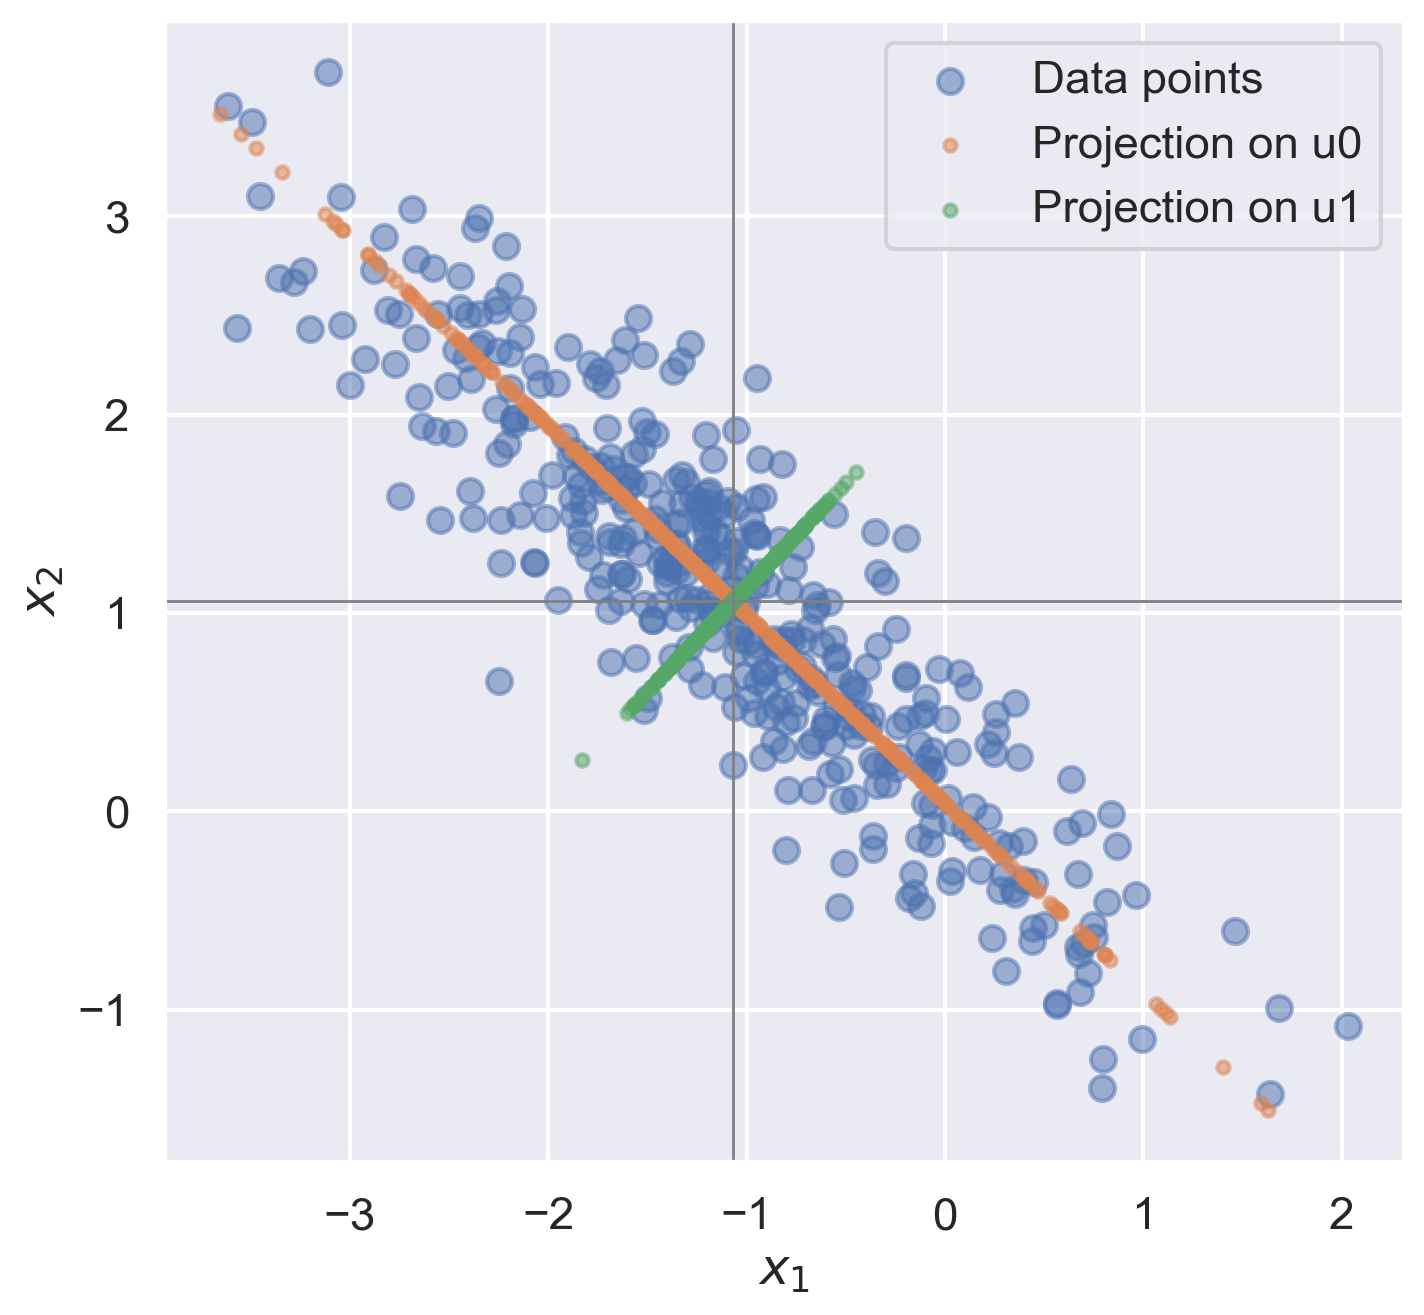

In [6]:
# Plot data points and their projections onto the first two principal directions.

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.5, label="Data points")
ax.scatter(
    x_samples_projected_u0[:, 0],
    x_samples_projected_u0[:, 1],
    alpha=0.5,
    s=20.0,
    label="Projection on u0",
)
ax.scatter(
    x_samples_projected_u1[:, 0],
    x_samples_projected_u1[:, 1],
    alpha=0.5,
    s=20.0,
    label="Projection on u1",
)
ax.axvline(x=x_mean[0], c="grey", lw=1)
ax.axhline(y=x_mean[1], c="grey", lw=1)
ax.set_aspect(1)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend()
plt.show()

In [7]:
# Report eigenvalues / explained variance to connect with the visualization
explained_ratio = s / s.sum()
print("Eigenvalues:", s)
print("Explained variance ratio:", explained_ratio)

Eigenvalues: [1.7587108  0.09708332]
Explained variance ratio: [0.94768638 0.05231362]


## Confidence Ellipse

The density of a multivariate Gaussian random variable with mean vector $\mathbf{\mu} \in \mathbb{R}^D$ and a $D \times D$-dimensional covariance matrix $\mathbf{\Sigma}$ is given by

$$
\mathcal{N}(x|\mu, \Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}} \exp \left\{ -\tfrac{1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu) \right\}
$$

Observe that the dependence of the Gaussian density wrt to $x$ is through the quadratic form

$$
\Delta^2 = (x - \mu)^T \Sigma^{-1}(x - \mu).
$$

The quantity $\Delta$ is referred to as the Mahalanobis distance.  

Diagonalizing the covariance matrix $\Sigma$, we have:

$$
\Sigma = \sum_{i=1}^D \lambda_i u_i u_i^T
$$

where we choose the eigenvectors $u_i$ to form an orthonormal set, i.e., $u_i^T u_j = \mathbf{1}_{i=j}$ and the $\lambda_i$ are the corresponding eigenvalues. Consequently,

$$
\Sigma^{-1} = \sum_{i=1}^D \frac{1}{\lambda_i} u_i u_i^T
$$

and we infer that

$$
\Delta^2 = \sum_{i=1}^D \frac{y_i^2}{\lambda_i}
$$

where we have defined: $y_i = u_i^T(x - \mu) \in \mathbb{R}$.

---

This corresponds to an ellipse centered at $\mu$ and whose major axes are defined by the eigenvectors $u_i$. The lengths of the major axis are given by $\sqrt{\lambda_i}$.  

The $\{y_i\}$ can be interpreted as a new coordinate system defined by the orthonormal vectors $u_i$ that are shifted and rotated with respect to the original coordinates $x_i$ coordinates. Forming the vector  

$$
y = (y_1, \ldots, y_D)^T,
$$

we have  

$$
y = U(x - \mu)
$$

where $U$ is a matrix whose rows are given by $u_i^T$.


In [8]:
def confidence_ellipse_param(X, n_std, n_points=int(1e3)):
    # n_std corresponds to Mahalanobis distance
    mean = X.mean(axis=0)
    cov = np.cov(X.T)
    P, s, Pt = np.linalg.svd(cov)
    t = np.linspace(0, 2 * np.pi, n_points)
    X_t = np.array(
        [n_std * np.sqrt(s[0]) * np.cos(t), n_std * np.sqrt(s[1]) * np.sin(t)]
    )
    # P corresponds to a rotation matrix
    x1_t, x2_t = P @ X_t + mean[:, None]
    return x1_t, x2_t

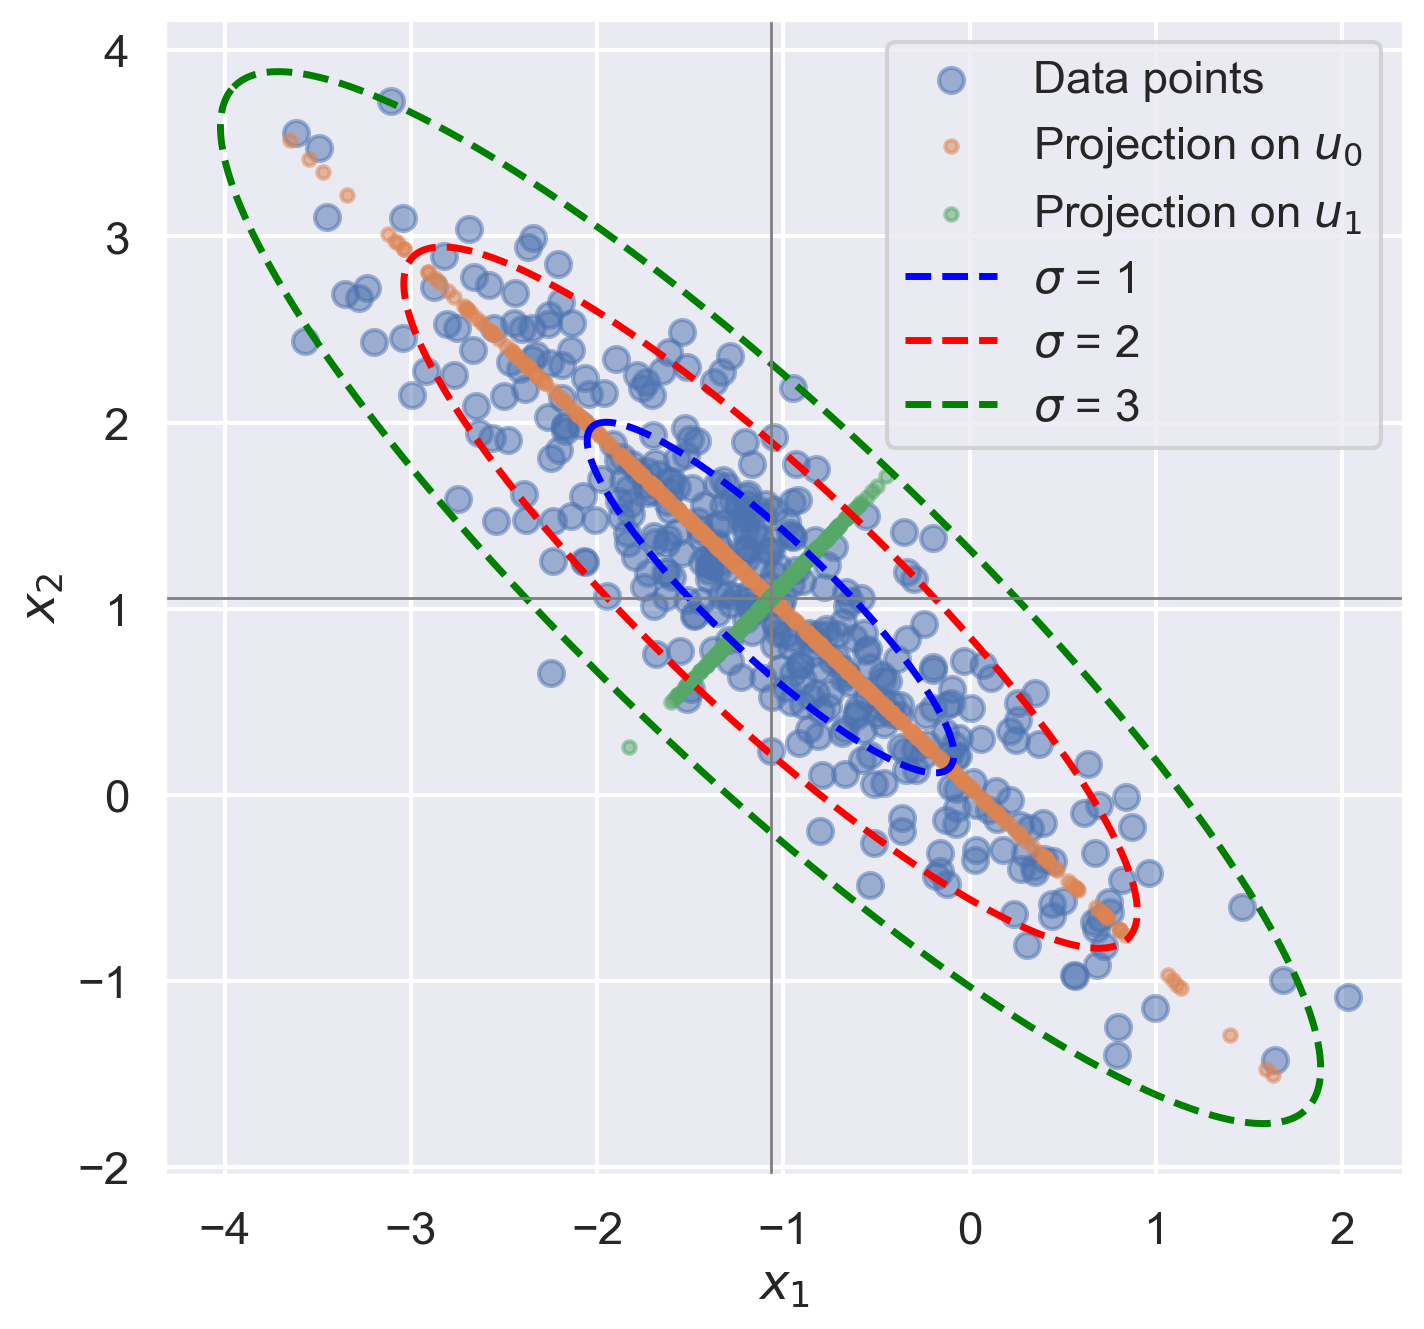

In [9]:
COLORS = ["blue", "red", "green"]

# Plot data points and their projections onto the first two principal directions
# along with confidence ellipses.

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.5, label="Data points")
for z, label in zip(
    [x_samples_projected_u0, x_samples_projected_u1], ["$u_0$", "$u_1$"], strict=False
):
    ax.scatter(
        z[:, 0],
        z[:, 1],
        alpha=0.5,
        s=20.0,
        label=f"Projection on {label}",
    )
for i in [1, 2, 3]:
    x1_t, x2_t = confidence_ellipse_param(x_samples, n_std=i)
    ax.plot(
        x1_t, x2_t, "--", linewidth=2.5, color=COLORS[i - 1], label=f"$\\sigma$ = {i}"
    )
ax.axvline(x=x_mean[0], c="grey", lw=1)
ax.axhline(y=x_mean[1], c="grey", lw=1)
ax.set_aspect(1)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend()
plt.show()

In [23]:
# -------------------------------------------------------------------
# Utilities
# -------------------------------------------------------------------


def project_data_onto_principal_components(
    mean=[0, 0], cov=[[1, 0], [0, 1]], n_samples=500, seed=1234
):
    rng = np.random.RandomState(seed)
    x = rng.multivariate_normal(mean=mean, cov=cov, size=n_samples)
    x_mean = x.mean(axis=0)
    x_centered = x - x_mean
    u, _, _ = np.linalg.svd(np.cov(x.T))
    xproj_v0 = x_centered @ u[:, :1] @ u[:, :1].T + x_mean
    xproj_v1 = x_centered @ u[:, 1:] @ u[:, 1:].T + x_mean
    return x, xproj_v0, xproj_v1


def confidence_ellipse_other(X, n_std, n_points=int(1e3)):
    cov = np.cov(X.T)
    P, s, Pt = np.linalg.svd(cov)
    t = np.linspace(0, 2 * np.pi, n_points)
    X_t = np.array(
        [n_std * np.sqrt(s[0]) * np.cos(t), n_std * np.sqrt(s[1]) * np.sin(t)]
    )
    x1_t, x2_t = P @ X_t + X.mean(axis=0)[:, None]
    return x1_t, x2_t


# -------------------------------------------------------------------
# Interactive sliders
# -------------------------------------------------------------------

mu1_slider = widgets.FloatSlider(
    description="$\\mu_1$", min=-1, max=1, step=0.1, value=0
)
mu2_slider = widgets.FloatSlider(
    description="$\\mu_2$", min=-1, max=1, step=0.1, value=0
)
var1_slider = widgets.FloatSlider(
    description="$\\sigma^2_1$", min=0.1, max=2.5, step=0.1, value=1
)
var2_slider = widgets.FloatSlider(
    description="$\\sigma^2_2$", min=0.1, max=2.5, step=0.1, value=1
)
rho_slider = widgets.FloatSlider(
    description="$\\rho$", min=-1, max=1, step=0.05, value=0
)
n_std_slider = widgets.FloatSlider(
    description="$n_{\\sigma}$", min=0.3, max=3.0, step=0.3, value=1
)

row_1 = HBox([mu1_slider, mu2_slider])
row_2 = HBox([var1_slider, var2_slider])
row_3 = HBox([rho_slider, n_std_slider])
ui = VBox([row_1, row_2, row_3])

# -------------------------------------------------------------------
# Update function for interactive plot
# -------------------------------------------------------------------


def update(mu1, mu2, var1, var2, rho, n_std):
    mean = np.array([mu1, mu2])
    cov = np.array([[var1, rho * var1 * var2], [rho * var1 * var2, var2]])

    x, xproj_v0, xproj_v1 = project_data_onto_principal_components(mean=mean, cov=cov)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect(1)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    ax.scatter(x[:, 0], x[:, 1], alpha=0.3)
    ax.scatter(xproj_v0[:, 0], xproj_v0[:, 1], label="Projection on $u_0$", alpha=0.3)
    ax.scatter(xproj_v1[:, 0], xproj_v1[:, 1], label="Projection on $u_1$", alpha=0.3)

    x1_t, x2_t = confidence_ellipse_param(x, n_std=n_std)
    ax.plot(
        x1_t,
        x2_t,
        "r-",
        linewidth=2.5,
        label=f"confidence ellipse $n_\\sigma={n_std:.3f}$",
    )

    ax.legend(loc="lower left")
    plt.show()


out = widgets.interactive_output(
    update,
    {
        "mu1": mu1_slider,
        "mu2": mu2_slider,
        "var1": var1_slider,
        "var2": var2_slider,
        "rho": rho_slider,
        "n_std": n_std_slider,
    },
)

display(ui, out)


Output()

If $X \sim \mathcal{N}(\mu, \Sigma)$ then the squared Mahalanobis distance
$$
\Delta^2 = (x-\mu)^\top \Sigma^{-1} (x-\mu)
$$
follows a $\chi_d^2$ distribution with df = d (the data dimension): 

Therefore
$$
\mathbb{P}(\Delta \le \sigma) = \mathbb{P}(\Delta^2 \le \sigma^2) = F_{\chi^2}(\sigma^2; \text{df}=d),
$$
i.e., the $\chi^2$ CDF evaluated at $\sigma^2$.  

This is what the cell below implements via 
`scipy.stats.chi2.cdf(sig**2, df=dim)` to compute the proportion enclosed by 
an n_std confidence ellipse.

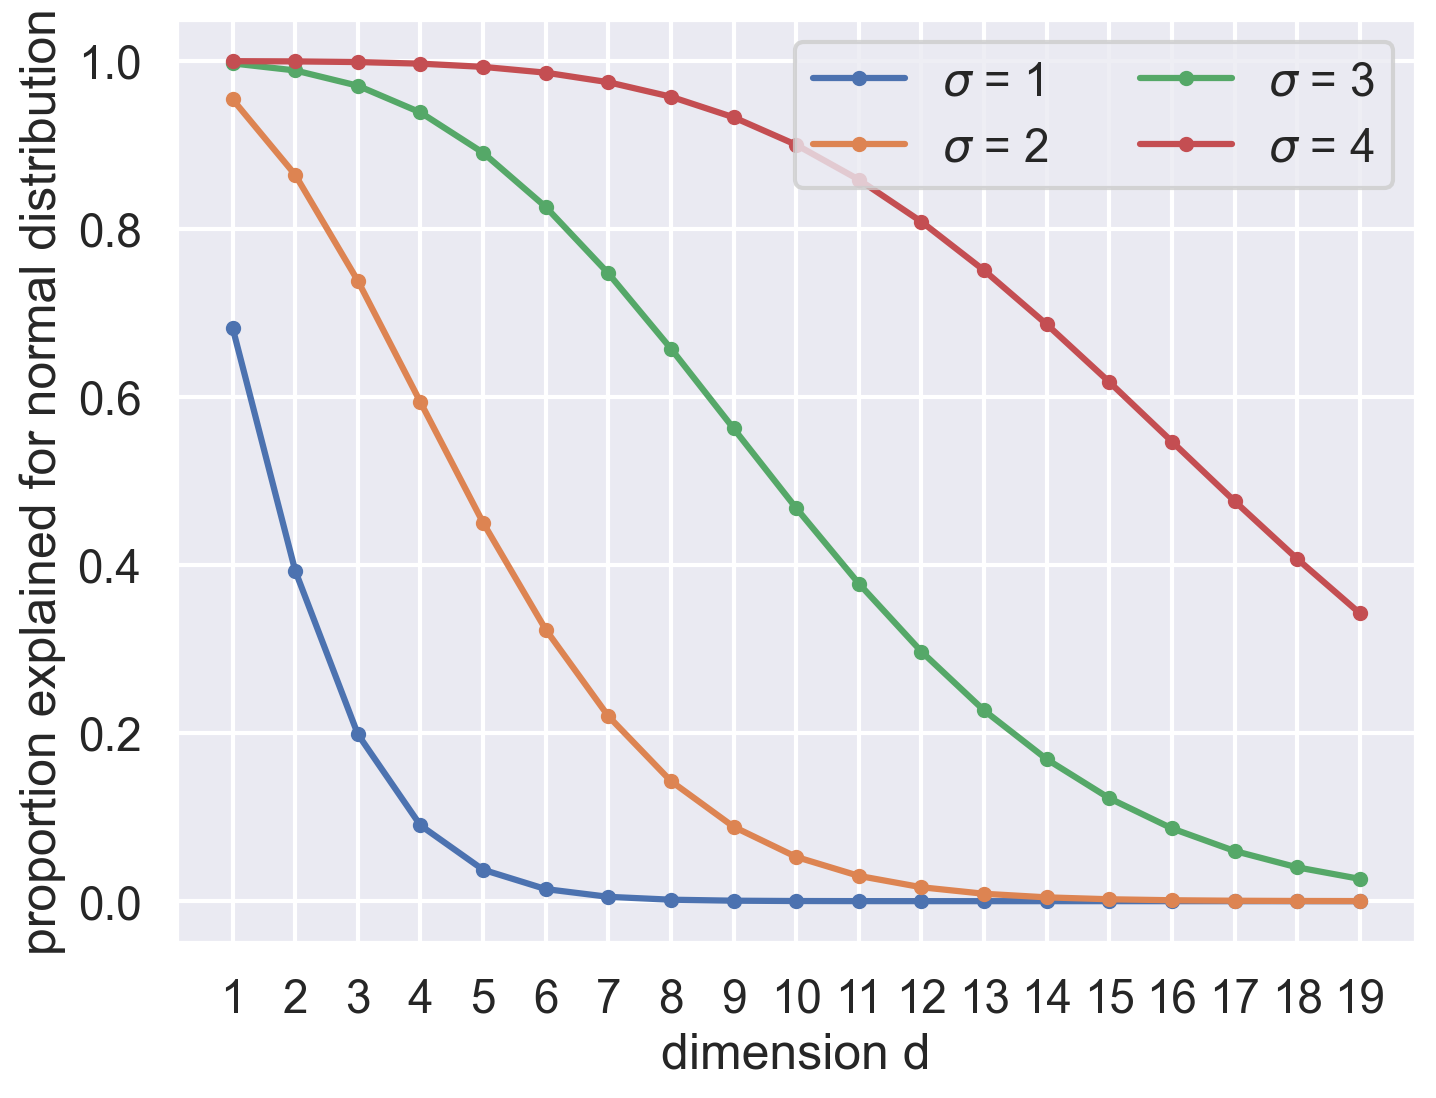

In [40]:
# -------------------------------------------------------------------
# Function: proportion of normal distribution inside n_std in dim dimensions
# -------------------------------------------------------------------
def proportion_normal(dim=1.0, sig=1.0):
    return stats.chi2(df=dim).cdf(sig**2)


# -------------------------------------------------------------------
# Plot proportion explained as function of dimension
# -------------------------------------------------------------------
tab_dim = np.asarray(np.arange(1, 20))

plt.close()
plt.figure()

for sig in [1, 2, 3, 4]:
    plt.plot(
        tab_dim,
        proportion_normal(dim=tab_dim, sig=sig),
        ".-",
        label=f"$\\sigma$ = {sig}",
    )

plt.ylabel("proportion explained for normal distribution")
plt.xlabel("dimension d")
plt.xticks(tab_dim)
plt.legend(ncol=2)
plt.show()

We recover the 68/95/99.7 rule for the univariate Gaussian distribution
when d=1.

In [47]:
dim = 1
for sig in [1, 2, 3]:
    print(
        f"Proportion enclosed for dim={dim}, sig={sig}: "
        f"{proportion_normal(dim=dim, sig=sig):.3f}"
    )

Proportion enclosed for dim=1, sig=1: 0.683
Proportion enclosed for dim=1, sig=2: 0.954
Proportion enclosed for dim=1, sig=3: 0.997


In [48]:
dim = 2
for sig in [1, 2, 3]:
    print(
        f"Proportion enclosed for dim={dim}, sig={sig}: "
        f"{proportion_normal(dim=dim, sig=sig):.3f}"
    )

Proportion enclosed for dim=2, sig=1: 0.393
Proportion enclosed for dim=2, sig=2: 0.865
Proportion enclosed for dim=2, sig=3: 0.989


In [49]:
dim = 5
for sig in [1, 2, 3]:
    print(
        f"Proportion enclosed for dim={dim}, sig={sig}: "
        f"{proportion_normal(dim=dim, sig=sig):.3f}"
    )

Proportion enclosed for dim=5, sig=1: 0.037
Proportion enclosed for dim=5, sig=2: 0.451
Proportion enclosed for dim=5, sig=3: 0.891
